# HAR CNN training 

In [463]:
# Imports
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [464]:
%run utils/utilities.py

In [465]:
class_label_vn = [u"Cổ tay",u"Cổ chân",u"Bả vai",u"Xoay người",u"Xoay đầu gối",u"Đi bộ",u"Chạy",u"Đạp xe",u"Đánh răng",u"Rửa tay",u"Thái",u"Trộn",u"Lên cầu thang",u"Xuống cầu thang"]

## Prepare data

In [466]:
rootDatasetDir = "./datasets/PTIT/normalized"
X_train, labels_train, list_ch_train = read_data(data_path="./datasets/PTIT/normalized", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test
assert list_ch_train == list_ch_test, "Mistmatch in channels!"

x_sensor_acc
x_watch_acc
x_watch_gyr
y_sensor_acc
y_watch_acc
y_watch_gyr
z_sensor_acc
z_watch_acc
z_watch_gyr
x_sensor_acc
x_watch_acc
x_watch_gyr
y_sensor_acc
y_watch_acc
y_watch_gyr
z_sensor_acc
z_watch_acc
z_watch_gyr


In [467]:
# Normalize?
# X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [468]:
# X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
#                                                 stratify = labels_train, random_state = 123)
X_tr = X_train
lab_tr = labels_train

One-hot encoding:

In [469]:
y_tr = one_hot(lab_tr)
# y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [470]:
# Imports
import tensorflow as tf

### Hyperparameters

In [471]:
batch_size = 600       # Batch size
seq_len = WINDOWN_SIZE          # Number of steps or window size
learning_rate = 0.0001
epochs = 1000

n_classes = NUM_CLASS
n_channels = NUM_CHANNEL
print "n_channels %d" % n_channels

n_channels 9


### Construct the graph
Placeholders

In [472]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [473]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [474]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [475]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [476]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    print "num epoch %d" % epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
#                 for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
#                     # Feed
#                     feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
#                     # Loss
#                     loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
#                     val_acc_.append(acc_v)
#                     val_loss_.append(loss_v)
                
                # Print info
#                 print("Epoch: {}/{}".format(e, epochs),
#                       "Iteration: {:d}".format(iteration),
#                       "Validation loss: {:6f}".format(np.mean(val_loss_)),
#                       "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

num epoch 1000
('Epoch: 0/1000', 'Iteration: 5', 'Train loss: 39.916981', 'Train acc: 0.090000')
('Epoch: 1/1000', 'Iteration: 10', 'Train loss: 31.383129', 'Train acc: 0.100000')


/home/tuyenlv17/python-virtualenv/diplomma/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tuyenlv17/python-virtualenv/diplomma/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('Epoch: 2/1000', 'Iteration: 15', 'Train loss: 26.642103', 'Train acc: 0.070000')
('Epoch: 3/1000', 'Iteration: 20', 'Train loss: 26.433458', 'Train acc: 0.071667')
('Epoch: 4/1000', 'Iteration: 25', 'Train loss: 22.830589', 'Train acc: 0.091667')
('Epoch: 5/1000', 'Iteration: 30', 'Train loss: 21.871632', 'Train acc: 0.088333')
('Epoch: 6/1000', 'Iteration: 35', 'Train loss: 19.743017', 'Train acc: 0.100000')
('Epoch: 7/1000', 'Iteration: 40', 'Train loss: 18.553200', 'Train acc: 0.110000')
('Epoch: 8/1000', 'Iteration: 45', 'Train loss: 18.960707', 'Train acc: 0.095000')
('Epoch: 9/1000', 'Iteration: 50', 'Train loss: 17.554333', 'Train acc: 0.083333')
('Epoch: 10/1000', 'Iteration: 55', 'Train loss: 15.902901', 'Train acc: 0.111667')
('Epoch: 11/1000', 'Iteration: 60', 'Train loss: 15.233346', 'Train acc: 0.113333')
('Epoch: 12/1000', 'Iteration: 65', 'Train loss: 14.743422', 'Train acc: 0.125000')
('Epoch: 13/1000', 'Iteration: 70', 'Train loss: 13.279920', 'Train acc: 0.121667')


('Epoch: 100/1000', 'Iteration: 505', 'Train loss: 2.309261', 'Train acc: 0.268333')
('Epoch: 101/1000', 'Iteration: 510', 'Train loss: 2.268650', 'Train acc: 0.271667')
('Epoch: 102/1000', 'Iteration: 515', 'Train loss: 2.252496', 'Train acc: 0.266667')
('Epoch: 103/1000', 'Iteration: 520', 'Train loss: 2.209825', 'Train acc: 0.278333')
('Epoch: 104/1000', 'Iteration: 525', 'Train loss: 2.295770', 'Train acc: 0.276667')
('Epoch: 105/1000', 'Iteration: 530', 'Train loss: 2.285615', 'Train acc: 0.273333')
('Epoch: 106/1000', 'Iteration: 535', 'Train loss: 2.225361', 'Train acc: 0.268333')
('Epoch: 107/1000', 'Iteration: 540', 'Train loss: 2.206347', 'Train acc: 0.268333')
('Epoch: 108/1000', 'Iteration: 545', 'Train loss: 2.332628', 'Train acc: 0.263333')
('Epoch: 109/1000', 'Iteration: 550', 'Train loss: 2.277012', 'Train acc: 0.275000')
('Epoch: 110/1000', 'Iteration: 555', 'Train loss: 2.223337', 'Train acc: 0.288333')
('Epoch: 111/1000', 'Iteration: 560', 'Train loss: 2.284141', 'Tr

('Epoch: 197/1000', 'Iteration: 990', 'Train loss: 1.773629', 'Train acc: 0.446667')
('Epoch: 198/1000', 'Iteration: 995', 'Train loss: 1.720121', 'Train acc: 0.433333')
('Epoch: 199/1000', 'Iteration: 1000', 'Train loss: 1.740606', 'Train acc: 0.435000')
('Epoch: 200/1000', 'Iteration: 1005', 'Train loss: 1.721034', 'Train acc: 0.438333')
('Epoch: 201/1000', 'Iteration: 1010', 'Train loss: 1.686649', 'Train acc: 0.463333')
('Epoch: 202/1000', 'Iteration: 1015', 'Train loss: 1.707867', 'Train acc: 0.410000')
('Epoch: 203/1000', 'Iteration: 1020', 'Train loss: 1.698476', 'Train acc: 0.431667')
('Epoch: 204/1000', 'Iteration: 1025', 'Train loss: 1.672313', 'Train acc: 0.456667')
('Epoch: 205/1000', 'Iteration: 1030', 'Train loss: 1.750446', 'Train acc: 0.426667')
('Epoch: 206/1000', 'Iteration: 1035', 'Train loss: 1.659584', 'Train acc: 0.443333')
('Epoch: 207/1000', 'Iteration: 1040', 'Train loss: 1.678885', 'Train acc: 0.440000')
('Epoch: 208/1000', 'Iteration: 1045', 'Train loss: 1.71

('Epoch: 293/1000', 'Iteration: 1470', 'Train loss: 1.342585', 'Train acc: 0.560000')
('Epoch: 294/1000', 'Iteration: 1475', 'Train loss: 1.345611', 'Train acc: 0.556667')
('Epoch: 295/1000', 'Iteration: 1480', 'Train loss: 1.336682', 'Train acc: 0.553333')
('Epoch: 296/1000', 'Iteration: 1485', 'Train loss: 1.256095', 'Train acc: 0.570000')
('Epoch: 297/1000', 'Iteration: 1490', 'Train loss: 1.325215', 'Train acc: 0.546667')
('Epoch: 298/1000', 'Iteration: 1495', 'Train loss: 1.320490', 'Train acc: 0.551667')
('Epoch: 299/1000', 'Iteration: 1500', 'Train loss: 1.300431', 'Train acc: 0.555000')
('Epoch: 300/1000', 'Iteration: 1505', 'Train loss: 1.295180', 'Train acc: 0.571667')
('Epoch: 301/1000', 'Iteration: 1510', 'Train loss: 1.330232', 'Train acc: 0.581667')
('Epoch: 302/1000', 'Iteration: 1515', 'Train loss: 1.304962', 'Train acc: 0.568333')
('Epoch: 303/1000', 'Iteration: 1520', 'Train loss: 1.266948', 'Train acc: 0.583333')
('Epoch: 304/1000', 'Iteration: 1525', 'Train loss: 1.

('Epoch: 389/1000', 'Iteration: 1950', 'Train loss: 1.061938', 'Train acc: 0.628333')
('Epoch: 390/1000', 'Iteration: 1955', 'Train loss: 1.025271', 'Train acc: 0.665000')
('Epoch: 391/1000', 'Iteration: 1960', 'Train loss: 1.003622', 'Train acc: 0.675000')
('Epoch: 392/1000', 'Iteration: 1965', 'Train loss: 0.966522', 'Train acc: 0.671667')
('Epoch: 393/1000', 'Iteration: 1970', 'Train loss: 1.008165', 'Train acc: 0.670000')
('Epoch: 394/1000', 'Iteration: 1975', 'Train loss: 1.015564', 'Train acc: 0.686667')
('Epoch: 395/1000', 'Iteration: 1980', 'Train loss: 0.979056', 'Train acc: 0.696667')
('Epoch: 396/1000', 'Iteration: 1985', 'Train loss: 1.003166', 'Train acc: 0.641667')
('Epoch: 397/1000', 'Iteration: 1990', 'Train loss: 0.965273', 'Train acc: 0.675000')
('Epoch: 398/1000', 'Iteration: 1995', 'Train loss: 1.018462', 'Train acc: 0.673333')
('Epoch: 399/1000', 'Iteration: 2000', 'Train loss: 0.985052', 'Train acc: 0.663333')
('Epoch: 400/1000', 'Iteration: 2005', 'Train loss: 0.

('Epoch: 485/1000', 'Iteration: 2430', 'Train loss: 0.787321', 'Train acc: 0.735000')
('Epoch: 486/1000', 'Iteration: 2435', 'Train loss: 0.777246', 'Train acc: 0.745000')
('Epoch: 487/1000', 'Iteration: 2440', 'Train loss: 0.769042', 'Train acc: 0.745000')
('Epoch: 488/1000', 'Iteration: 2445', 'Train loss: 0.774356', 'Train acc: 0.746667')
('Epoch: 489/1000', 'Iteration: 2450', 'Train loss: 0.779939', 'Train acc: 0.731667')
('Epoch: 490/1000', 'Iteration: 2455', 'Train loss: 0.728707', 'Train acc: 0.768333')
('Epoch: 491/1000', 'Iteration: 2460', 'Train loss: 0.714063', 'Train acc: 0.761667')
('Epoch: 492/1000', 'Iteration: 2465', 'Train loss: 0.754091', 'Train acc: 0.750000')
('Epoch: 493/1000', 'Iteration: 2470', 'Train loss: 0.746613', 'Train acc: 0.735000')
('Epoch: 494/1000', 'Iteration: 2475', 'Train loss: 0.779155', 'Train acc: 0.751667')
('Epoch: 495/1000', 'Iteration: 2480', 'Train loss: 0.752988', 'Train acc: 0.751667')
('Epoch: 496/1000', 'Iteration: 2485', 'Train loss: 0.

('Epoch: 581/1000', 'Iteration: 2910', 'Train loss: 0.554591', 'Train acc: 0.851667')
('Epoch: 582/1000', 'Iteration: 2915', 'Train loss: 0.557168', 'Train acc: 0.816667')
('Epoch: 583/1000', 'Iteration: 2920', 'Train loss: 0.540245', 'Train acc: 0.848333')
('Epoch: 584/1000', 'Iteration: 2925', 'Train loss: 0.552639', 'Train acc: 0.815000')
('Epoch: 585/1000', 'Iteration: 2930', 'Train loss: 0.523809', 'Train acc: 0.840000')
('Epoch: 586/1000', 'Iteration: 2935', 'Train loss: 0.589844', 'Train acc: 0.830000')
('Epoch: 587/1000', 'Iteration: 2940', 'Train loss: 0.592975', 'Train acc: 0.818333')
('Epoch: 588/1000', 'Iteration: 2945', 'Train loss: 0.551723', 'Train acc: 0.830000')
('Epoch: 589/1000', 'Iteration: 2950', 'Train loss: 0.526044', 'Train acc: 0.843333')
('Epoch: 590/1000', 'Iteration: 2955', 'Train loss: 0.578071', 'Train acc: 0.816667')
('Epoch: 591/1000', 'Iteration: 2960', 'Train loss: 0.521695', 'Train acc: 0.840000')
('Epoch: 592/1000', 'Iteration: 2965', 'Train loss: 0.

('Epoch: 677/1000', 'Iteration: 3390', 'Train loss: 0.430753', 'Train acc: 0.855000')
('Epoch: 678/1000', 'Iteration: 3395', 'Train loss: 0.398807', 'Train acc: 0.893333')
('Epoch: 679/1000', 'Iteration: 3400', 'Train loss: 0.415352', 'Train acc: 0.880000')
('Epoch: 680/1000', 'Iteration: 3405', 'Train loss: 0.400637', 'Train acc: 0.876667')
('Epoch: 681/1000', 'Iteration: 3410', 'Train loss: 0.407312', 'Train acc: 0.878333')
('Epoch: 682/1000', 'Iteration: 3415', 'Train loss: 0.418647', 'Train acc: 0.876667')
('Epoch: 683/1000', 'Iteration: 3420', 'Train loss: 0.414212', 'Train acc: 0.855000')
('Epoch: 684/1000', 'Iteration: 3425', 'Train loss: 0.383088', 'Train acc: 0.880000')
('Epoch: 685/1000', 'Iteration: 3430', 'Train loss: 0.402385', 'Train acc: 0.883333')
('Epoch: 686/1000', 'Iteration: 3435', 'Train loss: 0.426161', 'Train acc: 0.871667')
('Epoch: 687/1000', 'Iteration: 3440', 'Train loss: 0.369599', 'Train acc: 0.901667')
('Epoch: 688/1000', 'Iteration: 3445', 'Train loss: 0.

('Epoch: 773/1000', 'Iteration: 3870', 'Train loss: 0.297273', 'Train acc: 0.906667')
('Epoch: 774/1000', 'Iteration: 3875', 'Train loss: 0.311815', 'Train acc: 0.916667')
('Epoch: 775/1000', 'Iteration: 3880', 'Train loss: 0.276173', 'Train acc: 0.921667')
('Epoch: 776/1000', 'Iteration: 3885', 'Train loss: 0.289785', 'Train acc: 0.921667')
('Epoch: 777/1000', 'Iteration: 3890', 'Train loss: 0.296335', 'Train acc: 0.920000')
('Epoch: 778/1000', 'Iteration: 3895', 'Train loss: 0.319617', 'Train acc: 0.901667')
('Epoch: 779/1000', 'Iteration: 3900', 'Train loss: 0.296470', 'Train acc: 0.920000')
('Epoch: 780/1000', 'Iteration: 3905', 'Train loss: 0.321574', 'Train acc: 0.905000')
('Epoch: 781/1000', 'Iteration: 3910', 'Train loss: 0.311813', 'Train acc: 0.915000')
('Epoch: 782/1000', 'Iteration: 3915', 'Train loss: 0.290551', 'Train acc: 0.910000')
('Epoch: 783/1000', 'Iteration: 3920', 'Train loss: 0.265992', 'Train acc: 0.936667')
('Epoch: 784/1000', 'Iteration: 3925', 'Train loss: 0.

('Epoch: 869/1000', 'Iteration: 4350', 'Train loss: 0.260117', 'Train acc: 0.938333')
('Epoch: 870/1000', 'Iteration: 4355', 'Train loss: 0.194868', 'Train acc: 0.945000')
('Epoch: 871/1000', 'Iteration: 4360', 'Train loss: 0.222047', 'Train acc: 0.943333')
('Epoch: 872/1000', 'Iteration: 4365', 'Train loss: 0.217056', 'Train acc: 0.941667')
('Epoch: 873/1000', 'Iteration: 4370', 'Train loss: 0.206415', 'Train acc: 0.951667')
('Epoch: 874/1000', 'Iteration: 4375', 'Train loss: 0.200431', 'Train acc: 0.945000')
('Epoch: 875/1000', 'Iteration: 4380', 'Train loss: 0.259681', 'Train acc: 0.925000')
('Epoch: 876/1000', 'Iteration: 4385', 'Train loss: 0.228888', 'Train acc: 0.935000')
('Epoch: 877/1000', 'Iteration: 4390', 'Train loss: 0.255612', 'Train acc: 0.931667')
('Epoch: 878/1000', 'Iteration: 4395', 'Train loss: 0.211874', 'Train acc: 0.945000')
('Epoch: 879/1000', 'Iteration: 4400', 'Train loss: 0.232423', 'Train acc: 0.938333')
('Epoch: 880/1000', 'Iteration: 4405', 'Train loss: 0.

('Epoch: 965/1000', 'Iteration: 4830', 'Train loss: 0.185039', 'Train acc: 0.950000')
('Epoch: 966/1000', 'Iteration: 4835', 'Train loss: 0.191115', 'Train acc: 0.943333')
('Epoch: 967/1000', 'Iteration: 4840', 'Train loss: 0.188693', 'Train acc: 0.941667')
('Epoch: 968/1000', 'Iteration: 4845', 'Train loss: 0.181886', 'Train acc: 0.950000')
('Epoch: 969/1000', 'Iteration: 4850', 'Train loss: 0.170113', 'Train acc: 0.956667')
('Epoch: 970/1000', 'Iteration: 4855', 'Train loss: 0.172833', 'Train acc: 0.963333')
('Epoch: 971/1000', 'Iteration: 4860', 'Train loss: 0.192701', 'Train acc: 0.935000')
('Epoch: 972/1000', 'Iteration: 4865', 'Train loss: 0.206447', 'Train acc: 0.933333')
('Epoch: 973/1000', 'Iteration: 4870', 'Train loss: 0.178541', 'Train acc: 0.941667')
('Epoch: 974/1000', 'Iteration: 4875', 'Train loss: 0.159746', 'Train acc: 0.958333')
('Epoch: 975/1000', 'Iteration: 4880', 'Train loss: 0.182318', 'Train acc: 0.948333')
('Epoch: 976/1000', 'Iteration: 4885', 'Train loss: 0.

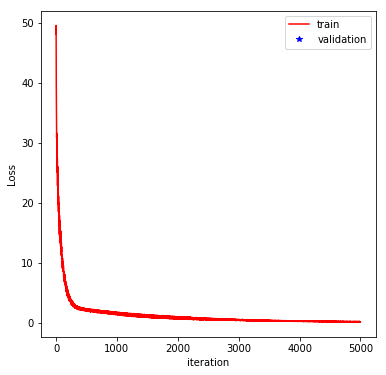

In [477]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

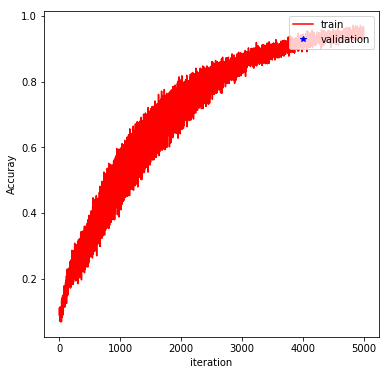

In [478]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
600
(7, array([  6.05e-10,   3.42e-14,   4.10e-18,   6.87e-11,   6.46e-10,
         4.38e-09,   1.50e-11,   9.10e-05,   1.10e-02,   9.44e-06,
         3.31e-01,   1.21e-11,   3.78e-07,   6.58e-01], dtype=float32))
(7, array([  2.28e-11,   2.31e-11,   7.03e-15,   3.26e-12,   3.92e-11,
         3.27e-06,   2.80e-09,   6.26e-01,   1.15e-02,   7.86e-06,
         3.36e-01,   5.71e-10,   1.03e-07,   2.71e-02], dtype=float32))
(7, array([  2.61e-12,   2.62e-10,   2.28e-13,   6.72e-15,   1.46e-07,
         1.37e-06,   6.66e-10,   1.76e-02,   3.73e-04,   2.75e-06,
         1.61e-01,   3.11e-11,   3.32e-09,   8.21e-01], dtype=float32))
(7, array([  1.33e-09,   4.96e-13,   1.25e-15,   3.02e-13,   1.33e-10,
         8.43e-13,   1.93e-13,   1.25e-01,   1.31e-04,   3.51e-07,
         3.14e-02,   8.82e-15,   2.00e-07,   8.44e-01], dtype=float32))
(7, array([  9.23e-12,   7.78e-19,   1.19e-20,   1.22e-18,   7.35e-15,
         5.23e-10,

(9, array([  7.34e-05,   2.77e-14,   1.93e-17,   7.52e-15,   1.35e-11,
         9.61e-11,   6.47e-06,   2.25e-05,   3.50e-05,   1.00e+00,
         1.72e-05,   2.59e-09,   2.82e-08,   3.99e-10], dtype=float32))
(9, array([  6.28e-04,   4.62e-12,   1.97e-14,   6.32e-13,   1.95e-10,
         4.30e-10,   4.61e-06,   3.64e-05,   3.93e-05,   9.99e-01,
         3.65e-05,   8.32e-08,   5.41e-07,   4.28e-10], dtype=float32))
(9, array([  1.02e-04,   7.11e-14,   9.82e-16,   2.75e-14,   7.14e-11,
         5.58e-11,   1.75e-07,   9.09e-06,   2.27e-05,   1.00e+00,
         6.07e-06,   5.60e-09,   1.54e-07,   1.15e-10], dtype=float32))
(9, array([  4.35e-04,   1.87e-13,   1.74e-15,   8.57e-14,   7.92e-11,
         2.34e-10,   3.67e-07,   1.13e-05,   5.59e-05,   9.99e-01,
         1.28e-05,   1.90e-08,   1.84e-08,   1.01e-10], dtype=float32))
(9, array([  3.38e-05,   5.63e-16,   8.65e-19,   3.44e-17,   7.11e-13,
         3.99e-13,   6.11e-09,   9.76e-08,   7.01e-07,   1.00e+00,
         1.81e-07,   2

(5, array([  4.79e-03,   1.84e-05,   6.37e-08,   1.56e-09,   4.10e-04,
         2.71e-03,   3.04e-02,   9.10e-02,   1.98e-04,   9.48e-05,
         8.70e-01,   1.38e-04,   1.24e-04,   2.38e-05], dtype=float32))
(5, array([  4.14e-02,   4.00e-05,   1.19e-04,   1.06e-01,   3.23e-02,
         8.18e-04,   6.66e-04,   5.27e-06,   1.00e-04,   1.37e-05,
         8.48e-03,   1.09e-03,   8.08e-01,   3.52e-04], dtype=float32))
(5, array([  6.41e-01,   1.24e-04,   1.78e-05,   1.85e-01,   2.30e-05,
         2.17e-04,   4.30e-06,   1.26e-06,   1.43e-02,   1.08e-07,
         1.66e-02,   8.39e-03,   1.32e-01,   1.92e-03], dtype=float32))
(5, array([  2.28e-02,   1.44e-05,   4.55e-07,   1.39e-05,   1.84e-04,
         4.26e-04,   1.19e-08,   3.40e-11,   6.50e-03,   4.52e-06,
         1.37e-07,   2.25e-02,   9.48e-01,   1.68e-08], dtype=float32))
(5, array([  4.41e-03,   7.41e-05,   2.30e-05,   1.09e-03,   1.79e-03,
         2.83e-02,   4.17e-04,   1.24e-03,   8.00e-01,   6.66e-02,
         8.46e-03,   4

(7, array([  9.31e-04,   9.55e-06,   7.19e-08,   2.73e-06,   2.09e-06,
         1.64e-04,   3.23e-05,   1.34e-02,   3.30e-01,   2.71e-01,
         3.67e-01,   5.33e-05,   5.66e-04,   1.64e-02], dtype=float32))
(7, array([  4.67e-13,   3.65e-16,   9.04e-20,   1.13e-15,   5.63e-13,
         5.47e-12,   9.01e-12,   9.56e-01,   2.47e-05,   1.76e-07,
         3.36e-03,   9.15e-14,   1.06e-11,   4.08e-02], dtype=float32))
(7, array([  7.43e-21,   5.36e-18,   3.25e-21,   5.25e-22,   5.52e-17,
         5.96e-15,   2.77e-20,   9.65e-01,   9.26e-07,   4.32e-13,
         3.36e-02,   6.44e-17,   4.40e-12,   1.01e-03], dtype=float32))
(7, array([  5.25e-15,   6.86e-15,   2.23e-23,   2.91e-18,   5.32e-10,
         7.57e-09,   1.09e-12,   2.64e-06,   5.94e-06,   2.79e-03,
         9.50e-01,   1.24e-13,   7.56e-10,   4.69e-02], dtype=float32))
(7, array([  1.79e-08,   1.01e-10,   2.11e-14,   8.73e-11,   6.19e-07,
         2.64e-07,   1.73e-10,   6.01e-01,   1.11e-01,   7.01e-06,
         1.86e-01,   4

         1.99e-08,   7.79e-01,   7.53e-03,   2.01e-09], dtype=float32))
(4, array([  2.50e-05,   7.83e-05,   2.16e-05,   8.53e-06,   9.75e-01,
         1.00e-05,   1.19e-04,   2.49e-09,   1.63e-09,   3.93e-06,
         1.84e-09,   2.41e-02,   1.85e-04,   1.46e-09], dtype=float32))
(4, array([  3.85e-06,   2.88e-08,   2.10e-06,   1.11e-04,   9.96e-01,
         8.25e-06,   3.54e-06,   6.76e-12,   3.75e-09,   3.14e-09,
         6.16e-10,   4.25e-03,   1.92e-05,   5.26e-09], dtype=float32))
(4, array([  1.03e-05,   1.80e-05,   5.86e-04,   1.68e-07,   9.99e-01,
         4.27e-05,   3.64e-05,   5.19e-12,   1.09e-12,   7.99e-10,
         2.94e-07,   3.91e-04,   4.33e-06,   2.87e-09], dtype=float32))
(4, array([  5.53e-02,   4.47e-03,   9.69e-03,   5.76e-01,   2.52e-02,
         5.88e-02,   1.15e-01,   8.16e-04,   6.05e-03,   1.67e-04,
         6.37e-02,   5.65e-02,   2.76e-02,   8.17e-05], dtype=float32))
(4, array([  1.82e-05,   1.42e-02,   1.92e-01,   4.43e-01,   1.70e-01,
         1.02e-01

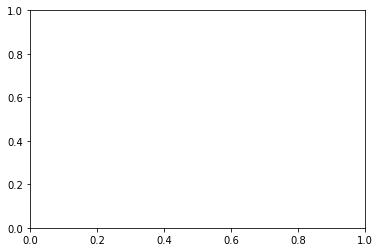

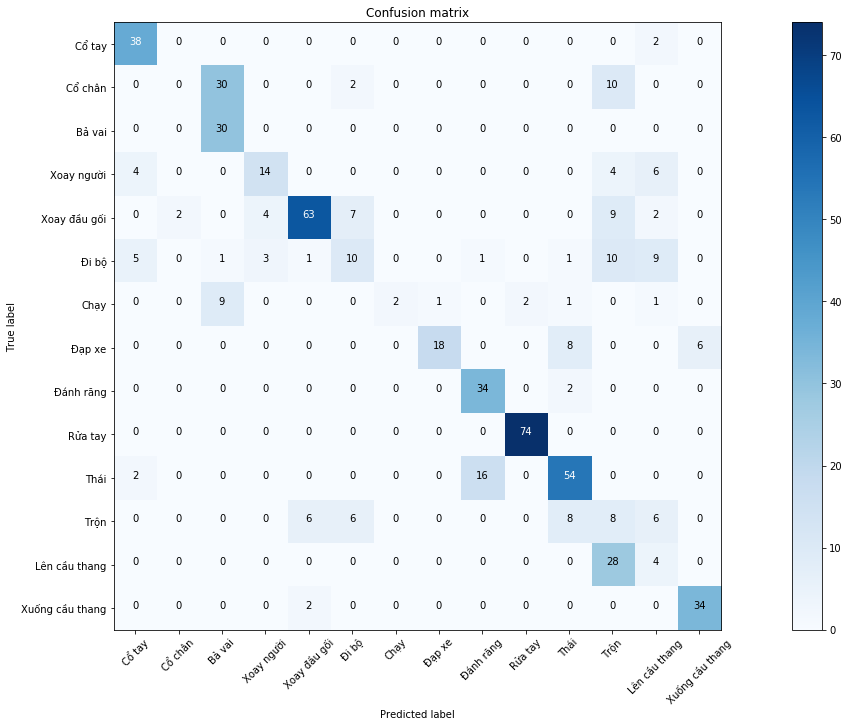

In [479]:
test_acc = []
with graph.as_default():
    prediction=tf.argmax(logits,1)
    class_probs = tf.nn.softmax(logits)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    y_pred = []
    y_true = []
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        batch_acc, batch_y_pred, probs = sess.run([accuracy, prediction, class_probs], feed_dict=feed)
        predict_class = [np.where(r==1)[0][0] for r in y_t ]
        y_true.extend(predict_class)
#         for idx, val in enumerate(predict_class):
#             if val == 10:
#                 print probs[idx]
        print len(predict_class)
        for idx, val in enumerate(predict_class):
            print (val, probs[idx])
        y_pred.extend(batch_y_pred)
        
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
#     print y_true
#     print y_pred
    sk_class_labels = [i for i in range(NUM_CLASS)]
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print precision_recall_fscore_support(y_true, y_pred, average=None, labels=sk_class_labels)
    print 'Accuracy:', accuracy_score(y_true, y_pred)
    print 'F1 score:', f1_score(y_true, y_pred, average='micro')
    print 'Recall:', recall_score(y_true, y_pred, average='micro')
    print 'Precision:', precision_score(y_true, y_pred, average='micro')
    print '\n clasification report:\n', classification_report(y_true,y_pred, digits=5)
    print '\n confussion matrix:\n',cnf_matrix
    fig, ax = plt.subplots() 
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plot_confusion_matrix(cnf_matrix, class_label_vn, title='Confusion matrix')

    plt.show()